# Imports and Definitions

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data
from sklearn.linear_model import LinearRegression, Lasso
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2
SEED = 1223

In [3]:
param_cols = ['batch_size','image_size','kernel_size','in_channels','out_channels','stride','padding']
models = {}
estimates = {}

# Conv2d Module
## Load Data

In [4]:
import os
os.getcwd()

'/home/getznerj/Documents/Repositories/ml-energy-estimator/experiments'

In [5]:
data_unnormalized = pd.read_csv('../data/conv2d-energies-parsed.csv')
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True, slurm_log_info=('../data/slurm-7511929.out','conv2d'))

Dropped observations with the following indices: [2, 7, 20, 55, 58, 76, 82, 101, 152, 166, 182, 222, 225, 261, 266, 288, 299, 315, 369, 371, 414, 454, 457, 484]
Final shape of data set: (476, 29)


## Feature Set: Parameters

In [6]:
print(f"Used features: {param_cols}")
dfs = split_data_set(data, param_cols, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=4, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'out_channels', 'stride', 'padding']
Number of observations: train/333, val/95 and test-set/48
Average R2 Cross-Validation Score: 0.613 (± 0.152)
Average MSE Cross-Validation: -4.576e-03 (± 1.139e-03)
Validation R2 Score: 0.748
Validation MSE: 5.519e-03


Test R2 Score: 0.426
Test MSE: 1.877e-03


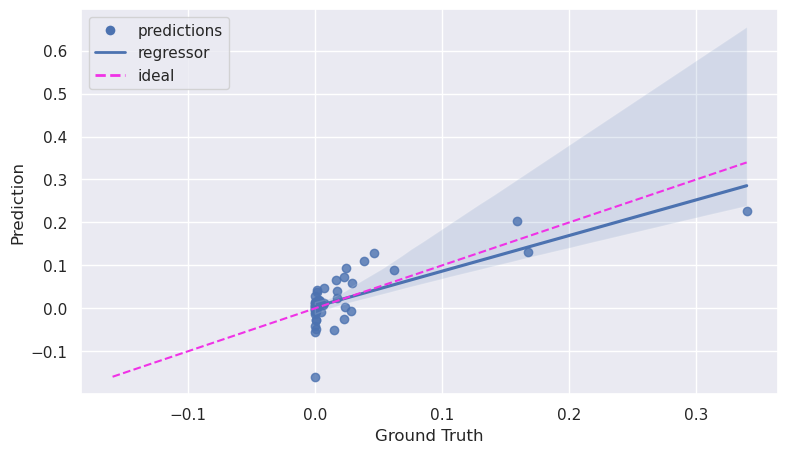

In [7]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [8]:
# save model & estimates
models['param'] = model
estimates['param'] = y_hat

### Notes
- there are only slight differences between using Lasso or LinearRegression
- Lasso seems slightly more robust as it has lower deviations in cross validation scores

## Feature-Set: Module Parameters + Log-Parameters


In [9]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'out_channels', 'stride', 'padding', 'log_batch_size', 'log_image_size', 'log_kernel_size', 'log_in_channels', 'log_out_channels', 'log_stride', 'log_padding']
Number of observations: train/333, val/95 and test-set/48
Average R2 Cross-Validation Score: 0.692 (± 0.117)
Average MSE Cross-Validation: -3.753e-03 (± 1.364e-03)
Validation R2 Score: 0.775
Validation MSE: 4.926e-03


Test R2 Score: 0.583
Test MSE: 1.365e-03


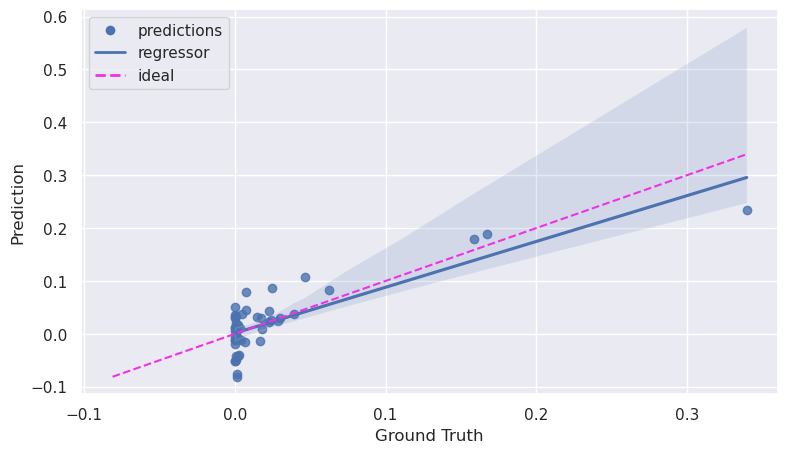

In [10]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [11]:
# save model & estimates
models['param_log_param'] = model
estimates['param_log_param'] = y_hat

### Notes
- LinearRegression works better without polynomial features than a Lasso regressor, but completely fails with polynomial features
- Generally more stable with log-features

## Feature-Set: MACs Only

In [12]:
dfs = split_data_set(data, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/333, val/95 and test-set/48
Average R2 Cross-Validation Score: 0.994 (± 0.003)
Average MSE Cross-Validation: -8.137e-05 (± 3.290e-05)
Validation R2 Score: 0.997
Validation MSE: 5.938e-05


Test R2 Score: 0.998
Test MSE: 7.709e-06


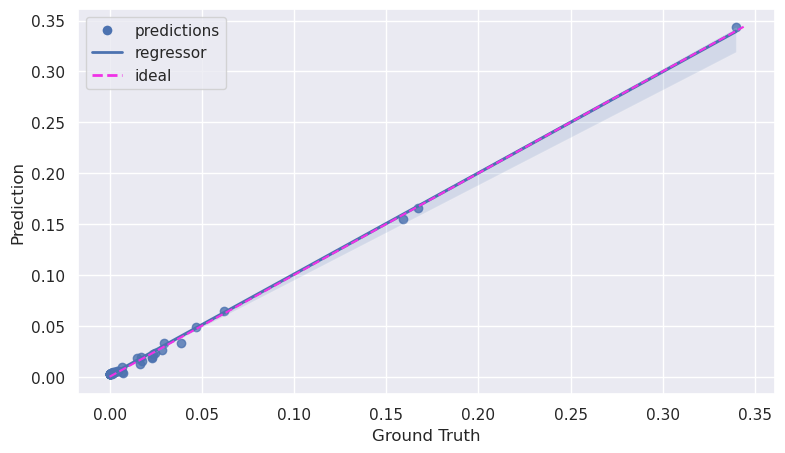

In [13]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [14]:
# save model & estimates
models['macs'] = model
estimates['macs'] = y_hat

### Notes
- easily outperforms all previousm feature sets
- extremely low deviations in R2 scores in the 5 folds
- very low test MSE

# Feature-Set: Module Parameters + MACs

In [15]:
dfs = split_data_set(data, param_cols + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/333, val/95 and test-set/48
Average R2 Cross-Validation Score: 0.995 (± 0.002)
Average MSE Cross-Validation: -6.183e-05 (± 2.204e-05)
Validation R2 Score: 0.998
Validation MSE: 4.462e-05


Test R2 Score: 0.996
Test MSE: 1.202e-05


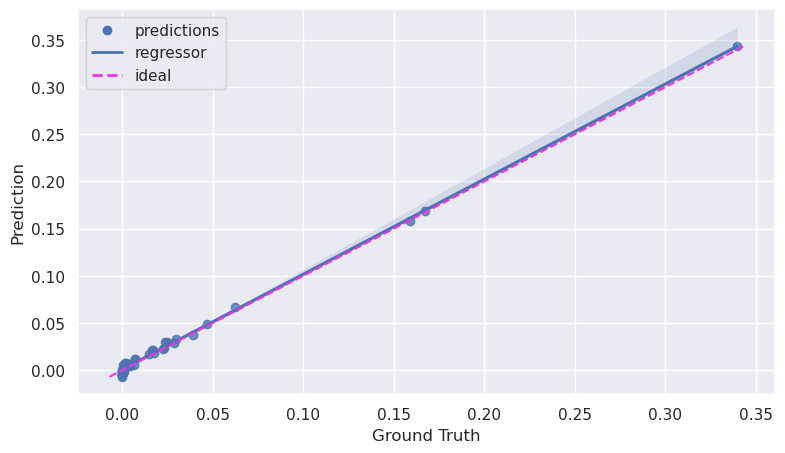

In [16]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [17]:
# save model & estimates
models['param_macs'] = model
estimates['param_macs'] = y_hat

### Notes
- fitting error slightly smaller on the folds, but minimally better performance on validation set compared to MACs only
- test score is lower and MSE significantly larger

## Feature-Set: Module Parameters + Log-Parameters + MACs

In [18]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
dfs = split_data_set(data_linear_with_log, param_cols_with_log + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/333, val/95 and test-set/48
Average R2 Cross-Validation Score: 0.995 (± 0.002)
Average MSE Cross-Validation: -5.855e-05 (± 1.867e-05)
Validation R2 Score: 0.998
Validation MSE: 4.279e-05


Test R2 Score: 0.995
Test MSE: 1.753e-05


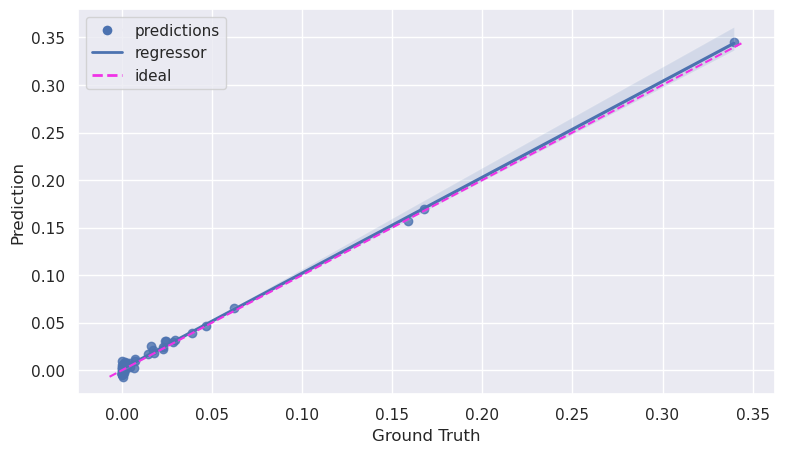

In [19]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [20]:
# save model & estimates
models['param_log_param_macs'] = model
estimates['param_log_param_macs'] = y_hat

### Notes
- similar performance to previous model
- no noticeable improvement comes from adding log parameters
- MACs only model much simpler and also performs better
- one could potentially also add polynomial terms here, but given the good score the increase in model complexity is hardly worth it. Also we did not notice and real performance improvement on the test set

# Comparison of all models

param                               0.426
param_log_param                     0.583
macs                                0.998
param_macs                          0.996
param_log_param_macs                0.995


<Figure size 800x600 with 0 Axes>

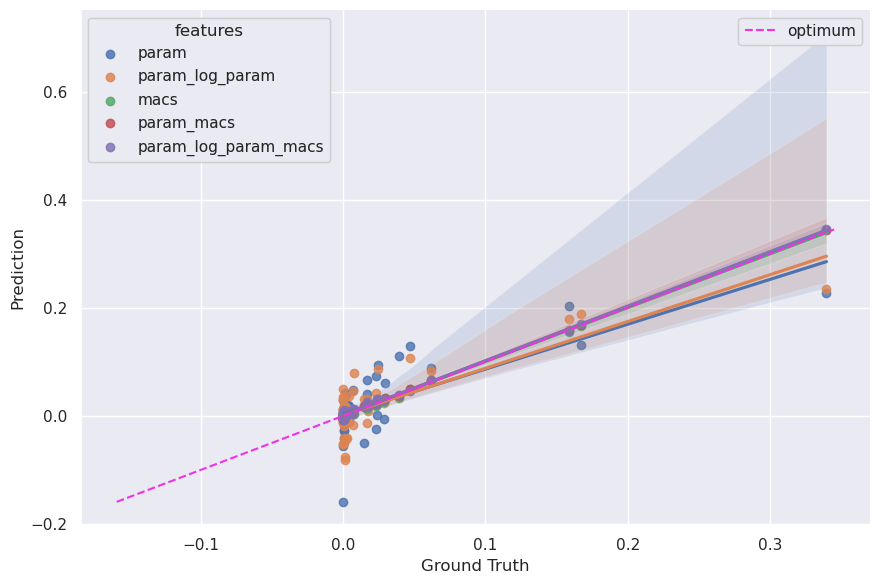

In [21]:
df_to_plot = pd.DataFrame(columns=["features","y_hat",'y'])
for model_name, model in models.items():
    new_df = pd.DataFrame(data={'features':[model_name]*len(dfs['y_test']),'y_hat':np.squeeze(estimates[model_name]),'y':np.squeeze(dfs['y_test'])})
    df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)
    print(f"{'{:<35}'.format(model_name)} {round(r2_score(dfs['y_test'], estimates[model_name]), 3)}")
min_x = min(min(df_to_plot.y_hat),min(df_to_plot.y))
max_x = max(max(df_to_plot.y_hat),max(df_to_plot.y))
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
g = sns.lmplot(data=df_to_plot, x="y", y="y_hat", hue="features", ci=95, height=6, aspect=1.5, facet_kws={'legend_out':False}, markers='o')
plt.plot([min_x, max_x], [min_x, max_x],ls='--', marker='', label='optimum', color="#f032e6")
line = Line2D([0], [0], ls='--', label='optimum', color='#f032e6')
g.set(xlabel='Ground Truth', ylabel='Prediction')
sns.move_legend(g, "upper left", bbox_to_anchor=(.1, .97))
legend1 = g.legend
legend2 = plt.legend(handles = [plt.plot([],ls="--", color=line.get_color())[0]], labels=[line.get_label()], loc='upper right')
g.fig.add_artist(legend2)
g.fig.add_artist(legend1)